# Earnings Forecast - Roland Berger Analytics Screening

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [82]:
sp500 = pd.read_csv('SP500_FUND_A_16052019.csv', index_col=0)
sp500.head()

,ticker,date,year,month,day,fyear,fmonth,ass_c_y,ass_nc_y,ass_tax_y,...,rat_y,rev_r_d_y,rev_s_g_a_y,roic_y,turn_acc_pay_y,turn_acc_rec_y,turn_inv_y,wrk_cap_y,fyearold,n2
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,3.671000e+09,3.883000e+09,0.0,...,2.207,0.1264,0.3137,0.1490,4.1255,7.5964,8.5354,2.008000e+09,2007,1
2,a,2008-10-31,2008,10,31,2008,10,3.182000e+09,3.825000e+09,0.0,...,2.392,0.1219,0.2939,0.1864,4.6941,7.6731,8.9589,1.852000e+09,2008,1
3,a,2009-10-31,2009,10,31,2009,10,3.961000e+09,3.651000e+09,0.0,...,3.527,0.1433,0.3577,0.0121,3.7951,6.5656,7.4808,2.838000e+09,2009,1
4,a,2010-10-31,2010,10,31,2010,10,6.169000e+09,3.527000e+09,0.0,...,2.001,0.1124,0.3218,0.0905,3.9107,7.4372,8.5868,3.086000e+09,2010,1
5,a,2011-10-31,2011,10,31,2011,10,5.569000e+09,3.488000e+09,0.0,...,3.032,0.0981,0.2735,0.1700,3.5592,7.6518,8.1970,3.732000e+09,2011,1


## 1. Data Preparation

### 1.1 Dataset containing 23 predictors

In [83]:
predictor_cols = ['ass_tot_y', 'goodwill_y', 'inc_rea_y', 'invest_y', 'rev_def_y', 'dps_y',
                  'eps_y', 'exp_r_d_y', 'marg_profit_y', 'rev_grw_y', 'cf_inv_y', 'exp_cap_y',
                  'ncf_bad_y', 'ncf_iad_y', 'g_cf_op_y', 'g_dps_y', 'g_eps_y', 'g_inv_y',
                  'be_ps_y', 'fcf_ps_y', 'inc_qua_y', 'payout_y', 'turn_inv_y']

df_predictors = df[predictor_cols]
df_predictors.head()

,ass_tot_y,goodwill_y,inc_rea_y,invest_y,rev_def_y,dps_y,eps_y,exp_r_d_y,marg_profit_y,rev_grw_y,...,ncf_iad_y,g_cf_op_y,g_dps_y,g_eps_y,g_inv_y,be_ps_y,fcf_ps_y,inc_qua_y,payout_y,turn_inv_y
v1,,,,,,,,,,,,,,,,,,,,,
1,7.554000e+09,7.360000e+08,2.172000e+09,194000000.0,249000000.0,0.0,1.62,685000000.0,0.118,0.0899,...,1.600000e+07,0.5284,0.0,-0.7888,0.0255,8.601,2.099,1.5188,0.0,8.5354
2,7.007000e+09,8.740000e+08,2.791000e+09,230000000.0,280000000.0,0.0,1.91,704000000.0,0.120,0.0653,...,-7.300000e+07,-0.2198,0.0,0.1790,0.0047,7.168,1.697,1.0909,0.0,8.9589
3,7.612000e+09,8.220000e+08,2.760000e+09,177000000.0,285000000.0,0.0,-0.09,642000000.0,-0.007,-0.2239,...,8.000000e+07,-0.4603,0.0,-1.0471,-0.1455,7.306,0.812,-13.1613,0.0,7.4808
4,9.696000e+09,1.950000e+09,3.444000e+09,142000000.0,358000000.0,0.0,1.97,612000000.0,0.126,0.2149,...,4.800000e+07,0.7598,0.0,22.8889,0.2971,9.384,1.741,1.0497,0.0,8.5868
5,9.057000e+09,1.996000e+09,4.456000e+09,117000000.0,389000000.0,0.0,2.92,649000000.0,0.153,0.2151,...,1.561000e+09,0.7549,0.0,0.4822,0.2542,12.415,3.141,1.2451,0.0,8.1970


### 1.2 Scaling variables of variables - share / absolute level

First, let's assess if the number of stocks vary over time. This helps us decide for an approach of scaling to the per stock level, leaving the numbers in absolute terms or using an alternative method.

In [84]:
df_shr_changes = df.groupby('ticker')['shr_y'].nunique()
tickers_with_shr_changes = df_shr_changes[df_shr_changes > 1].index.tolist()

if tickers_with_shr_changes:
    print(f"The 'shr_y' (shares per year) changes over time for the following tickers: {tickers_with_shr_changes}")
else:
    print("The 'shr_y' (shares per year) does not change over time for any ticker in the dataset.")


The 'shr_y' (shares per year) changes over time for the following tickers: ['a', 'aal', 'aap', 'aapl', 'abbv', 'abc', 'abt', 'acn', 'adbe', 'adi', 'adm', 'adp', 'ads', 'adsk', 'aee', 'aep', 'aes', 'aet', 'afl', 'agn', 'aig', 'aiv', 'aiz', 'ajg', 'akam', 'aks', 'alb', 'alk', 'all', 'alle', 'alxn', 'amat', 'amd', 'ame', 'amg', 'amgn', 'amp', 'amt', 'amzn', 'an', 'anf', 'antm', 'aon', 'apa', 'apc', 'apd', 'aph', 'are', 'arnc', 'ati', 'atvi', 'avb', 'avgo', 'avp', 'avy', 'awk', 'axp', 'ayi', 'azo', 'ba', 'bac', 'bax', 'bbby', 'bbt', 'bby', 'bc', 'bcr', 'bdx', 'ben', 'bfb', 'big', 'biib', 'bk', 'blk', 'bll', 'bms', 'bmy', 'brkb', 'bsx', 'bwa', 'bxp', 'c', 'ca', 'cag', 'cah', 'cat', 'cb', 'cbg', 'cboe', 'cbs', 'cce', 'cci', 'ccl', 'celg', 'cern', 'cf', 'cfg', 'chd', 'chk', 'chrw', 'chtr', 'ci', 'cien', 'cinf', 'cl', 'clf', 'clx', 'cma', 'cmcsa', 'cme', 'cmg', 'cmi', 'cms', 'cnc', 'cnp', 'cnx', 'cof', 'cog', 'coh', 'col', 'coo', 'cop', 'cost', 'coty', 'cpb', 'crm', 'csco', 'csx', 'ctas', 'ctl

For many of the companies in the dataset, share number vary over time. A share split for example would cause the share number to double, while the earnings per share would halve.

However, after assessing whether to scale the varaibles that are recorded in absolute terms, for the purpose of this exercise, we will scale all variables to a per share level.

For a more extensive analysis than a 24h project, one could further assess to use relative metrics, such as R&D spend / revenue.

In [ ]:
# all variables that are on a absolute level

### check again

absolute_variables_to_scale = {
    'ass_tot_y': 'ass_ps_y',
    'goodwill_y': 'goodwill_ps_y',
    'inc_rea_y': 'inc_rea_ps_y',
    'invest_y': 'invest_ps_y',
    'rev_def_y': 'rev_def_ps_y',
    'dps_y': 'dps_ps_y',
    'eps_y': 'eps_ps_y',
    'exp_r_d_y': 'exp_r_d_ps_y',
    'cf_inv_y': 'cf_inv_ps_y',
    'exp_cap_y': 'exp_cap_ps_y',
    'ncf_bad_y': 'ncf_bad_ps_y',
    'ncf_iad_y': 'ncf_iad_ps_y'
}

# scale each variable
for original, new_name in variables_to_scale.items():
    df[new_name] = df[original] / df['shr_y']

# update predictor columns list with new per-share variables
predictor_cols_scaled = [
    'ass_ps_y', 'goodwill_ps_y', 'inc_rea_ps_y', 'invest_ps_y', 'rev_def_ps_y', 
    'dps_y', 'eps_y', 'exp_r_d_ps_y', 'marg_profit_y', 'rev_grw_y', 'cf_inv_ps_y', 
    'exp_cap_ps_y', 'ncf_bad_ps_y', 'ncf_iad_ps_y', 'g_cf_op_y', 'g_dps_y', 'g_eps_y', 
    'g_inv_y', 'be_ps_y', 'fcf_ps_y', 'inc_qua_y', 'payout_y', 'turn_inv_y'
]

# Now use predictor_cols_scaled for your analysis
X = df[predictor_cols_scaled]
X.head()

,ass_ps_y,goodwill_ps_y,inc_rea_ps_y,invest_ps_y,rev_def_ps_y,dps_y,eps_y,exp_r_d_ps_y,marg_profit_y,rev_grw_y,...,ncf_iad_ps_y,g_cf_op_y,g_dps_y,g_eps_y,g_inv_y,be_ps_y,fcf_ps_y,inc_qua_y,payout_y,turn_inv_y
v1,,,,,,,,,,,,,,,,,,,,,
1,19.172589,1.868020,5.512690,0.492386,0.631980,0.0,1.62,1.738579,0.118,0.0899,...,0.040609,0.5284,0.0,-0.7888,0.0255,8.601,2.099,1.5188,0.0,8.5354
2,19.303030,2.407713,7.688705,0.633609,0.771350,0.0,1.91,1.939394,0.120,0.0653,...,-0.201102,-0.2198,0.0,0.1790,0.0047,7.168,1.697,1.0909,0.0,8.9589
3,22.000000,2.375723,7.976879,0.511561,0.823699,0.0,-0.09,1.855491,-0.007,-0.2239,...,0.231214,-0.4603,0.0,-1.0471,-0.1455,7.306,0.812,-13.1613,0.0,7.4808
4,27.942363,5.619597,9.925072,0.409222,1.031700,0.0,1.97,1.763689,0.126,0.2149,...,0.138329,0.7598,0.0,22.8889,0.2971,9.384,1.741,1.0497,0.0,8.5868
5,26.100865,5.752161,12.841499,0.337176,1.121037,0.0,2.92,1.870317,0.153,0.2151,...,4.498559,0.7549,0.0,0.4822,0.2542,12.415,3.141,1.2451,0.0,8.1970


### 1.3 Creating target variables

First, we create a DataFrame that contains the data for the current financial year.

In [86]:
# creating df with target variable & additional features

Y = sp500[['ticker', 'date', 'year', 'month', 'day', 'fyear', 'shr_y','fmonth', 'eps_y']]
Y.head()

,ticker,date,year,month,day,fyear,shr_y,fmonth,eps_y
v1,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,394000000.0,10,1.62
2,a,2008-10-31,2008,10,31,2008,363000000.0,10,1.91
3,a,2009-10-31,2009,10,31,2009,346000000.0,10,-0.09
4,a,2010-10-31,2010,10,31,2010,347000000.0,10,1.97
5,a,2011-10-31,2011,10,31,2011,347000000.0,10,2.92


In [87]:
# creating a new target variable - displays if current eps_y is negative - to be shifted

Y['neg_eps'] = Y['eps_y'] < 0
Y.head()

/var/folders/yn/2tfz0n9x7m3dkwb69m05y8lw0000gn/T/ipykernel_46091/3034734157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['neg_eps'] = Y['eps_y'] < 0


,ticker,date,year,month,day,fyear,shr_y,fmonth,eps_y,neg_eps
v1,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,394000000.0,10,1.62,False
2,a,2008-10-31,2008,10,31,2008,363000000.0,10,1.91,False
3,a,2009-10-31,2009,10,31,2009,346000000.0,10,-0.09,True
4,a,2010-10-31,2010,10,31,2010,347000000.0,10,1.97,False
5,a,2011-10-31,2011,10,31,2011,347000000.0,10,2.92,False


Now, having all the data in a Dataframe, we need to shift the two target variables - these will later be the target variables for the prediction model.

In [88]:
# shift eps_y and neg_eps by 1 to creat the actual target variables

Y['eps_y_forward'] = Y['eps_y'].shift(-1)
Y['neg_eps_forward'] = Y['neg_eps'].shift(-1)
Y.tail()

/var/folders/yn/2tfz0n9x7m3dkwb69m05y8lw0000gn/T/ipykernel_46091/1219482884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['eps_y_forward'] = Y['eps_y'].shift(-1)
/var/folders/yn/2tfz0n9x7m3dkwb69m05y8lw0000gn/T/ipykernel_46091/1219482884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['neg_eps_forward'] = Y['neg_eps'].shift(-1)


,ticker,date,year,month,day,fyear,shr_y,fmonth,eps_y,neg_eps,eps_y_forward,neg_eps_forward
v1,,,,,,,,,,,,
5473,zts,2012-12-31,2012,12,31,2012,500000000.0,12,0.87,False,1.01,False
5474,zts,2013-12-31,2013,12,31,2013,500002000.0,12,1.01,False,1.16,False
5475,zts,2014-12-31,2014,12,31,2014,501055000.0,12,1.16,False,0.68,False
5476,zts,2015-12-31,2015,12,31,2015,499707000.0,12,0.68,False,1.66,False
5477,zts,2016-12-31,2016,12,31,2016,495715000.0,12,1.66,False,NaN,NaN


In [89]:
# filter for one company to check correctness

company = 'orcl'
ads = Y[Y['ticker'] == company]

ads

,ticker,date,year,month,day,fyear,shr_y,fmonth,eps_y,neg_eps,eps_y_forward,neg_eps_forward
v1,,,,,,,,,,,,
3799,orcl,2008-05-31,2008,5,31,2008,5.133000e+09,5,1.08,False,1.10,False
3800,orcl,2009-05-31,2009,5,31,2009,5.070000e+09,5,1.10,False,1.22,False
3801,orcl,2010-05-31,2010,5,31,2010,5.014000e+09,5,1.22,False,1.69,False
3802,orcl,2011-05-31,2011,5,31,2011,5.048000e+09,5,1.69,False,1.99,False
3803,orcl,2012-05-31,2012,5,31,2012,5.015000e+09,5,1.99,False,2.29,False
3804,orcl,2013-05-31,2013,5,31,2013,4.769000e+09,5,2.29,False,2.42,False
3805,orcl,2014-05-31,2014,5,31,2014,4.528000e+09,5,2.42,False,2.26,False
3806,orcl,2015-05-31,2015,5,31,2015,4.404000e+09,5,2.26,False,2.11,False
3807,orcl,2016-05-31,2016,5,31,2016,4.221000e+09,5,2.11,False,1.69,False


Before moving on to the EDA, we want to first make sure that the data is prepared properly.

#### Previous assumption was that a stock split for example might cause a significant structural break in the data.
First research has yielded that this might not be the case, because EPS is always reported on a split-adjusted basis by financial data providers. However, we want to check if this is the case and if so, adjust for it.

We will research one specific commpanies where a stock split occurred in the time period of the data. Then we will check if the data is actually reported on a split-adjusted basis to validate our new hypothesis.

According to credible sources, including the company website, Nike (ticker: nke) had a 2-for1 stock split in 12/23/2015. Accordingly, we will check how the number of shares changed over time:


https://investors.nike.com/default.aspx?SectionId=d8f26c6c-d0e6-416b-af21-d4193a16d945&LanguageId=1

In [90]:
print(nke[nke['year'].isin([2014, 2015, 2016])]['shr_y'])


v1
3632    1.756278e+09
3633    1.719495e+09
3634    1.684722e+09
Name: shr_y, dtype: float64


Accordingly, as the number of shares does not double from 2015 to 2016, we can continue with this hypothesis and now have confirmed that there is *no adjustment necessary*.

### 1.4 Outlier Detection & Treatment

### 1.5 EDA

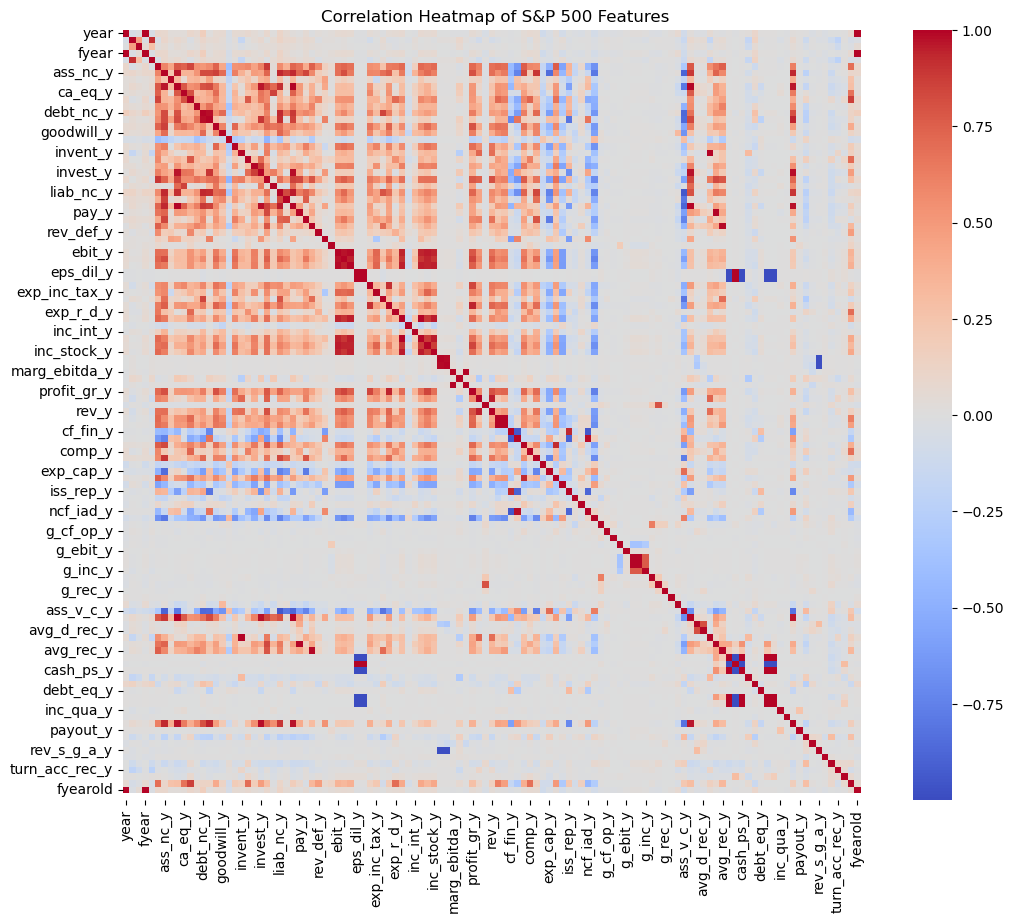

In [95]:
plt.figure(figsize=(12, 10))
# Select only numeric columns for correlation matrix
numeric_df = sp500.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of S&P 500 Features')
plt.show()